##### Most of the codes below are copied from '02.mnist_abnormality_module.py'

In [1]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import numpy as np
import exp_aux_util as exp
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from noise_util import add_distortion_noise, add_distortion_blur
from noise_util import rotate90_if_not_zero
import mnist_softmax as ms # run this cell twice to erase unwanted result output
softkld = ms.softkld
import matplotlib.pyplot as plt
import sklearn.metrics as sk
%matplotlib inline


[MNIST SUCCESS DETECTION]
MNIST Error (%)| Prediction Prob (mean, std) | PProb Right            (mean, std) | PProb Wrong (mean, std):
2.18999981880188 | 0.9899579 0.052967437 | 0.9940217 0.037173312 | 0.80846 0.1808637
Success base rate (%): 97.81 (9781/10000)
KL[p||u]: Right/Wrong classification distinction
AUPR (%): 99.91
AUROC (%): 96.42
Prediction Prob: Right/Wrong classification distinction
AUPR (%): 99.91
AUROC (%): 96.41

Error Detection
Error base rate (%): 2.19 (219/10000)
AUPR (%): 44.26
AUROC (%): 96.42
Prediction Prob: Right/Wrong classification distinction
AUPR (%): 44.85
AUROC (%): 96.41

[MNIST-FashionMNIST anomaly detection]
In-dist max softmax distribution (mean, std):
0.9899579 0.052967437
Out-of-dist max softmax distribution(mean, std):
0.91532385 0.14896864

Normality Detection
Normality base rate (%): 50.0
KL[p||u]: Normality Detection
AUPR (%): 68.46
AUROC (%): 76.07
Prediction Prob: Normality Detection
AUPR (%): 69.86
AUROC (%): 76.32

Abnormality Detection
Abn

In [4]:
# Custom layer for merging 3 layers into.
class Merge3Ways(keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Merge3Ways, self).__init__(**kwargs)

    def build(self, input_shape):

        # Destructuring shapes
        shape_x, shape_h2, shape_logits, shape_rec =\
                list(map(lambda shape: int(shape[1]), input_shape))

        self.weight1 = self.add_weight(name='h2_to_merge',
                                       shape=(shape_h2, self.output_dim))
        self.weight2 = self.add_weight(name='logits_to_merge',
                                       shape=(shape_logits, self.output_dim))
        self.weight3 = self.add_weight(name='rec_to_merge',
                                       shape=(shape_rec, self.output_dim))
        self.bias = self.add_weight(name='bias',
                                    shape=(self.output_dim,))
        super(Merge3Ways, self).build(input_shape)

    def call(self, inputs):

        x, h2, logits_out, reconstruction = inputs
        a1 = K.dot(h2, self.weight1)
        a2 = K.dot(logits_out, self.weight2)
        a3 = K.dot(K.square(reconstruction-x), self.weight3)
        return (a1 + a2 + a3) + self.bias

In [5]:
# returns trained auxiliary base model
def train_aux_base_model():
    # TRAIN MODEL
    training_epochs = 10
    image_size = 28
    input_dim = image_size * image_size
    n_labels = 10
    bottleneck_dim = 128
    batch_size = 128

    # Base model
    inputs = Input(shape=(input_dim, ), name='image_input')
    h1 = Dense(256, activation='relu', name='h1')(inputs)
    h2 = Dense(256, activation='relu', name='h2')(h1)

    # Softmax logits output
    h3 = Dense(256, activation='relu', name='h3')(h2)
    logits_out = Dense(n_labels, activation='softmax', name='logits_out')(h3)

    # Reconstruction image output
    bottleneck = Dense(bottleneck_dim,
                       activation='relu',
                       name='bottleneck')(h2)
    decode1 = Dense(256, activation='relu', name='decode1')(bottleneck)
    decode2 = Dense(256, activation='relu', name='decode2')(decode1)
    reconstruction = Dense(input_dim, name='rec_output')(decode2)

    # Instantiate base model
    base_model = Model(inputs, [h2, logits_out, reconstruction], name='base')

    base_model.compile(optimizer='adam',
                       loss={'logits_out': 'sparse_categorical_crossentropy',
                             'rec_output': 'mean_squared_error'},
                       loss_weights={'logits_out': 0.9,
                                     'rec_output': 0.1})

    base_model.fit(mnist_train_x,
                   {'logits_out': mnist_train_y,
                    'rec_output': mnist_train_x},
                   epochs=training_epochs, batch_size=batch_size)

    # test_loss, test_acc
    test_result = base_model.evaluate(x=mnist_test_x,
                                      y={'logits_out': mnist_test_y,
                                         'rec_output': mnist_test_x})

    print("metric names:", base_model.metrics_names)
    print(test_result)

    # SAVE MODEL
    keras.models.save_model(base_model, "./mnist_aux_base.hdf5")
    return base_model

In [6]:
# Continue to base model, merge all output layers to external module
def train_abnormal_model(base_model):

    epochs = 10
    batch_size = 128

    image_inputs = base_model.inputs[0]

    # Deconstruct outputs from previous base model
    h2, logits_out, reconstruction = base_model.outputs

    merged = Merge3Ways(512)([image_inputs, h2, logits_out, reconstruction])

    risk_1 = Dense(128, activation='relu', name='risk_1')(merged)
    risk_out = Dense(1, name='risk_out', activation='sigmoid')(risk_1)

    # Instantiate abnormality module
    aux_model = Model(image_inputs, [logits_out, risk_out])

    # Freeze base model layers to prevent optimization
    for l in base_model.layers:
        l.trainable = False

    # Setup datasets for training abnormality module
    batches = []

    # We'll take train:test datasets at the ratio of 2:1 in single batch,
    # then will tweak half of them.
    def mnist_fetcher(mnist_x, chunksize, mnist_y=None):
        num_chunks = mnist_x.shape[0] // chunksize
        for i in range(num_chunks):
            if mnist_y is not None:
                yield [mnist_x[i * chunksize: (i + 1) * chunksize],
                       mnist_y[i * chunksize: (i + 1) * chunksize]]
            else:
                yield mnist_x[i * chunksize: (i + 1) * chunksize]

    chunksize_train = int(batch_size*(4/6))
    chunksize_test = int(batch_size*(2/6))

    tcu = chunksize_train // 4
    for (train_x, train_y), test in\
        zip(mnist_fetcher(mnist_train_x, chunksize_train, mnist_train_y),
            mnist_fetcher(mnist_test_x, chunksize_test)):

        # In-distribution dataset(half of batch)
        bx0 = train_x[:tcu]  # 1/6
        bx1 = test  # 3/6

        # Out-of-distribution dataset(rest half of batch)
        bx2 = train_x[tcu:2*tcu]  # 4/6
        bx3 = train_x[2*tcu:3*tcu]  # 5/6
        bx4 = train_x[3*tcu:]  # 6/6
        by4 = train_y[3*tcu:]

        assert(len(bx4) == len(by4))

        # Make OOD samples by adding noise(see image_augmenting.py)
        bx2 = add_distortion_noise(bx2)
        bx3 = add_distortion_blur(bx3)
        bx4 = rotate90_if_not_zero(bx4, by4)

        # Stack altogether
        bx = np.vstack((bx0, bx1, bx2, bx3, bx4))
        by = np.zeros(len(bx))
        by[:len(bx0) + len(bx1)] = 1
        batch = [bx, by]

        batches.append(batch)

    aux_model.compile(optimizer='adam',
                      loss={'risk_out': 'binary_crossentropy'})
    aux_model.summary()

    for epoch in range(epochs):
        for batch in batches:
            bx, by = batch
            aux_model.fit(bx,
                          {'risk_out': by},
                          batch_size=batch_size,
                          verbose=0)

    len_testset = mnist_test_x.shape[0]
    test_result = aux_model.evaluate(x=mnist_test_x,
                                     y=np.ones(shape=(len_testset, 1)))

    print("metric names:", aux_model.metrics_names)
    print(test_result)

    # Save model
    keras.models.save_model(aux_model, "./mnist_abnormal.hdf5")
    return aux_model


In [7]:
# Load MNIST
mnist = keras.datasets.mnist
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y)\
    = mnist.load_data()
mnist_train_x = np.reshape(mnist_train_x, [-1, 28*28]) / 255.
mnist_test_x = np.reshape(mnist_test_x, [-1, 28*28]) / 255.

# Load Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(fmnist_train_x, fmnist_train_y), (fmnist_test_x, fmnist_test_y)\
    = fashion_mnist.load_data()
fmnist_train_x = np.reshape(fmnist_train_x, [-1, 28*28]) / 255.
fmnist_test_x = np.reshape(fmnist_test_x, [-1, 28*28]) / 255.

In [8]:
base_model_path = './mnist_aux_base.hdf5'
abnormal_model_path = './mnist_abnormal.hdf5'

# Build base model if not exists
if not os.path.exists(base_model_path):
    base_model = train_aux_base_model()
else:
    base_model = keras.models.load_model(base_model_path)

# Build abnormality module
if not os.path.exists(abnormal_model_path):
    abnormal_model = train_abnormal_model(base_model)
else:
    abnormal_model = train_abnormal_model(base_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 256)          200960      image_input[0][0]                
__________________________________________________________________________________________________
h2 (Dense)                      (None, 256)          65792       h1[0][0]                         
__________________________________________________________________________________________________
bottleneck (Dense)              (None, 128)          32896       h2[0][0]                         
__________________________________________________________________________________________________
decode1 (D

In [9]:
s_prob_right, s_prob_wrong, kl_right, kl_wrong =\
    exp.right_wrong_distinction(abnormal_model,
                                mnist_test_x,
                                mnist_test_y,)
risk_in_f, risk_out_f =\
    exp.in_out_distinction(abnormal_model,
                           mnist_test_x,
                           fmnist_test_x,
                           "FashionMNIST")
risk_in_w, risk_out_w =\
    exp.in_out_distinction(abnormal_model,
                           mnist_test_x,
                           np.random.normal(size=(10000, 28*28)),
                           "WhiteNoise")
risk_in_u, risk_out_u =\
    exp.in_out_distinction(abnormal_model,
                           mnist_test_x,
                           np.random.uniform(size=(10000, 28*28)),
                           "UniformNoise")


[MNIST SUCCESS DETECTION]
MNIST Error (%)| Prediction Prob (mean, std) | PProb Right (mean, std) | PProb Wrong (mean, std):
1.8499970436096191 | 0.99024963 0.05453094 | 0.9936901 0.041456293 | 0.8077105 0.18870063
Success base rate (%): 98.15 (9815/10000)
KL[p||u]: Right/Wrong classification distinction
AUPR (%): 99.92
AUROC (%): 96.2
Prediction Prob: Right/Wrong classification distinction
AUPR (%): 99.92
AUROC (%): 96.19

Error Detection
Error base rate (%): 1.85 (185/10000)
AUPR (%): 35.76
AUROC (%): 96.2
Prediction Prob: Right/Wrong classification distinction
AUPR (%): 37.01
AUROC (%): 96.19

[MNIST-FashionMNIST anomaly detection]
In-dist max softmax distribution (mean, std):
0.9999879 0.00028249706
Out-of-dist max softmax distribution(mean, std):
0.26576 0.43727076

Normality Detection
Normality base rate (%): 50.0
Prediction Prob: Normality Detection
AUPR (%): 89.23
AUROC (%): 93.86

Abnormality Detection
Abnormality base rate (%): 50.0
Prediction Prob: Abnormality Detection
AUPR

In [10]:
# Bind right/wrong distinction result
sp_rw = [s_prob_right, s_prob_wrong]
kl_rw = [kl_right, kl_wrong]

# Bind in/out of distribution detecting result of MNIST-FashionMNIST
risk_iof = [risk_in_f, risk_out_f]

# Bind in/out of distribution detecting result of MNIST-WhiteNoise
risk_iow = [risk_in_w, risk_out_w]

# Bind in/out of distribution detecting result of MNIST-UniformNoise
risk_iou = [risk_in_u, risk_out_u]

aux_result = [ ('right/wrong', sp_rw), 
               ('in/out, MNIST/FashionMNIST', risk_iof), 
               ('in/out, MNIST/WhiteNoise', risk_iow),
               ('in/out, MNIST/UniformNoise', risk_iou),
               ('right/wrong', kl_rw)]

# And we also have softkld from previous experiment

In [11]:
def safe_risky_to_roc_curve(safe, risky, inverse=False):
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    if inverse:
        labels[safe.shape[0]:] += 1
    else:
        labels[:safe.shape[0]] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    aupr = round(100*sk.average_precision_score(labels, examples), 2)
    auroc = round(100*sk.roc_auc_score(labels, examples), 2)
    fpr, tpr, _ = sk.roc_curve(labels, examples)
    return fpr, tpr, aupr, auroc

<Figure size 432x288 with 0 Axes>

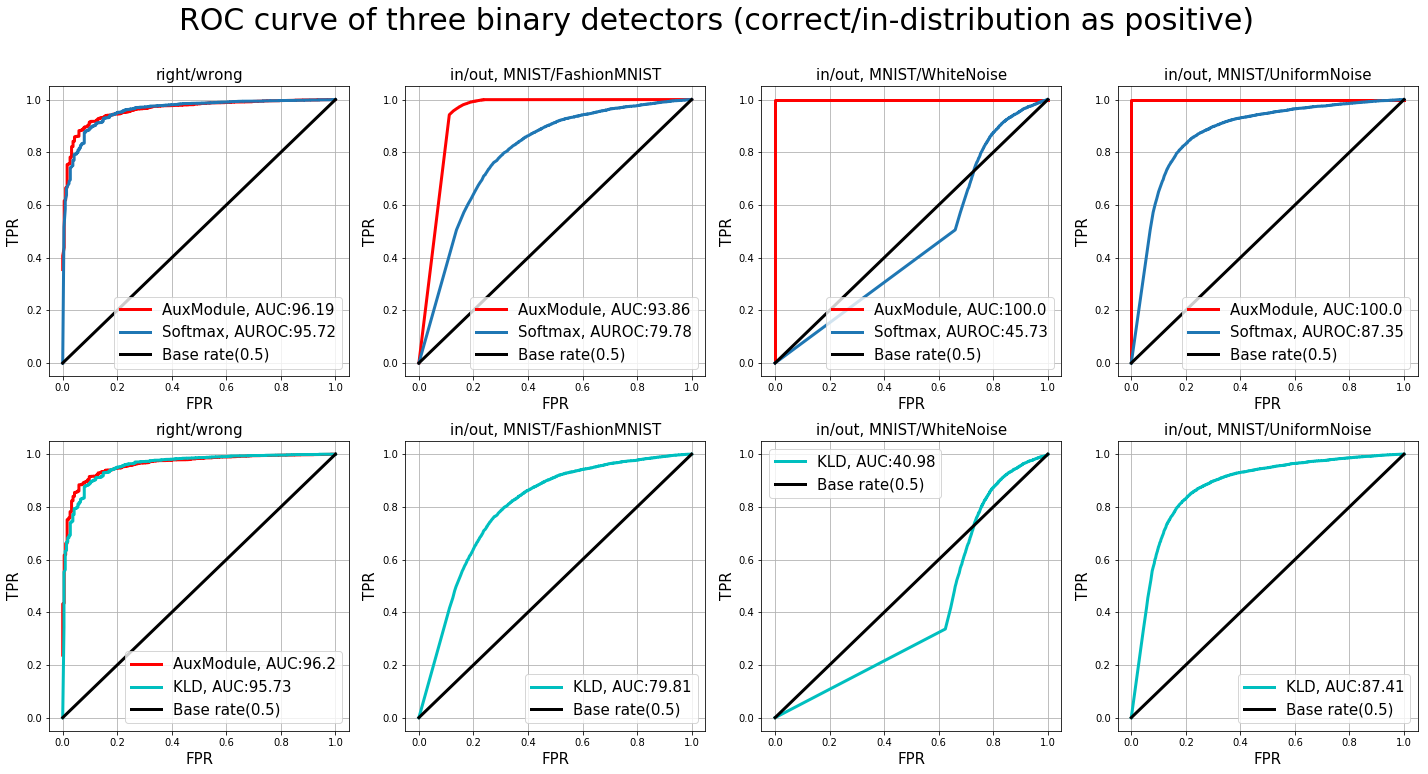

In [32]:
rows, cols = 2, 4
fz = 15
linewidth = 3

plt.tight_layout()
plt.figure(figsize=(20,10))
plt.suptitle('ROC curve of three binary detectors (correct/in-distribution as positive)', y=1.07, fontsize=30)

for i, (plotname, (safe, risky)) in enumerate(softkld):
    plt.subplot(2, 4, i+1)
    plt.tight_layout()
    if i < 5:
        safe_aux, risky_aux = aux_result[i][1]
        fpr_aux, tpr_aux, aupr_aux, auroc_aux = safe_risky_to_roc_curve(safe_aux, risky_aux)
        plt.plot(fpr_aux, tpr_aux, 'r-', label='AuxModule, AUC:{}'.format(auroc_aux), lw=linewidth)
        if auroc_aux > 99:
            plt.vlines([0], 0, 1, 'r', lw=linewidth)
        
    fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(safe, risky)
    plt.plot(fpr, tpr,
             '-' if i < 4 else 'c-',
             label='Softmax, AUROC:{}'.format(auroc) if i < 4 else 'KLD, AUC:{}'.format(auroc),
             lw=linewidth)

    plt.plot([0, 1], 'k-', lw=3, label='Base rate(0.5)')
    plt.legend(fontsize=fz)
    plt.title(plotname, fontsize=fz)
    plt.xlabel("FPR", fontsize=fz)
    plt.ylabel("TPR", fontsize=fz)
    plt.grid(True)